<a href="https://colab.research.google.com/github/utkarshg1/PCA-SVD-SMOTE/blob/main/Loan_Prediction_Extra_Techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [108]:
from warnings import filterwarnings
filterwarnings("ignore")

In [1]:
import pandas as pd

In [2]:
url = "https://raw.githubusercontent.com/utkarshg1/Neural-Net-Datasets/refs/heads/main/train_loan.csv"
df = pd.read_csv(url)
df.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(6), object

In [4]:
df.isna().sum()

,0
id,0
person_age,0
person_income,0
person_home_ownership,0
person_emp_length,0
loan_intent,0
loan_grade,0
loan_amnt,0
loan_int_rate,0
loan_percent_income,0


In [5]:
df.duplicated().sum()

0

In [6]:
X = df.drop(columns = ["id", "loan_status"])
Y = df[["loan_status"]].values.flatten()

In [7]:
cat = list(X.columns[X.dtypes == "object"])
con = list(X.columns[X.dtypes != "object"])

In [8]:
cat

['person_home_ownership',
 'loan_intent',
 'loan_grade',
 'cb_person_default_on_file']

In [9]:
con

['person_age',
 'person_income',
 'person_emp_length',
 'loan_amnt',
 'loan_int_rate',
 'loan_percent_income',
 'cb_person_cred_hist_length']

In [10]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.compose import ColumnTransformer

In [11]:
num_pipe = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler(),
    PCA(n_components=4)
)

In [12]:
cat_pipe = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop="first"),
    TruncatedSVD(n_components=4)
)

In [13]:
pre = ColumnTransformer(
    [
        ("num", num_pipe, con),
        ("cat", cat_pipe, cat),
    ],
    remainder="passthrough"
)

In [14]:
X_pre = pre.fit_transform(X)
X_pre

array([[ 1.8864337 , -0.33636458, -2.17201778, ...,  0.53715067,
         0.80079173,  0.21384529],
       [-1.34120929, -0.98205456,  0.05051075, ..., -0.4872611 ,
        -0.38868259,  0.42797733],
       [ 0.73221283, -0.2236763 , -0.66676555, ...,  0.03335389,
        -0.12817331, -0.53047471],
       ...,
       [-1.20320863,  0.18057225, -0.32665135, ..., -0.31071094,
         0.72532138,  0.28282099],
       [-1.52401832, -0.45213215, -0.66347457, ..., -0.18706493,
         0.75639705,  0.3115019 ],
       [ 0.30471636,  1.03688654,  0.01996259, ...,  0.75772266,
        -0.0859484 , -0.63690611]])

In [15]:
X_pre.shape

(58645, 8)

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
xtrain, xtest, ytrain, ytest = train_test_split(X_pre, Y, test_size=0.2, random_state=42)

In [18]:
xtrain.shape

(46916, 8)

In [19]:
xtest.shape

(11729, 8)

In [20]:
from imblearn.over_sampling import SMOTE

In [21]:
smote = SMOTE(random_state=42)
xtrain_res, ytrain_res = smote.fit_resample(xtrain, ytrain)

In [22]:
import numpy as np
u, f = np.unique(ytrain_res, return_counts=True)
dict(zip(u, f))

{0: 40208, 1: 40208}

In [63]:
from xgboost import XGBClassifier

In [64]:
model = XGBClassifier(
    max_depth = 3,
    n_estimators = 2000,
    learning_rate = 0.1
)
model.fit(xtrain_res, ytrain_res)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=2000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [65]:
model.score(xtrain_res, ytrain_res)

0.9344036012733784

In [66]:
model.score(xtest, ytest)

0.9298320402421348

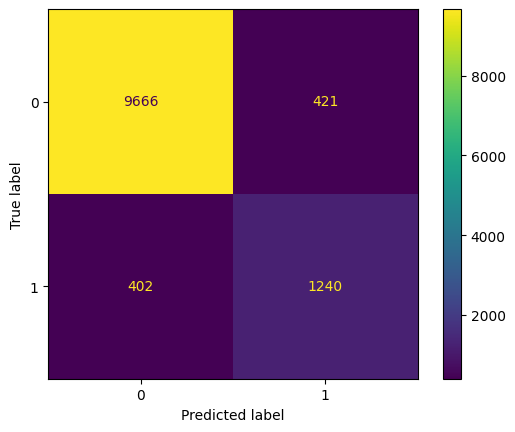

In [67]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(model, xtest, ytest)

In [68]:
ypred_test = model.predict(xtest)
ypred_test[0:5]

array([0, 0, 0, 0, 0])

In [69]:
ytest[0:5]

array([0, 0, 1, 0, 0])

In [70]:
from sklearn.metrics import classification_report

print(classification_report(ytest, ypred_test))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     10087
           1       0.75      0.76      0.75      1642

    accuracy                           0.93     11729
   macro avg       0.85      0.86      0.85     11729
weighted avg       0.93      0.93      0.93     11729



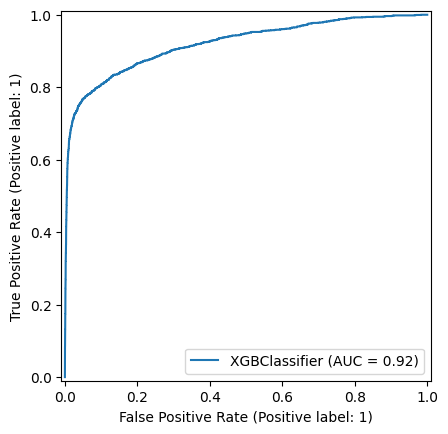

In [71]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(model, xtest, ytest)

In [72]:
from sklearn.model_selection import cross_val_score

In [61]:
scores_f1 = cross_val_score(model, xtrain_res, ytrain_res, cv=5, scoring="f1_macro")
scores_f1

array([0.86092506, 0.93102984, 0.93003452, 0.93314627, 0.93077304])

In [73]:
scores_f1.mean()

0.9171817487548269

0.9171817487548269

In [74]:
scores_auc = cross_val_score(model, xtrain_res, ytrain_res, cv=5, scoring="roc_auc")
scores_auc

array([0.93755523, 0.98251042, 0.98277546, 0.98454421, 0.98398663])

In [75]:
scores_auc.mean()

0.9742743897017434

In [76]:
model.feature_importances_

array([0.02783252, 0.20429678, 0.11183481, 0.05712787, 0.16233017,
       0.21709979, 0.1179944 , 0.10148366], dtype=float32)

In [77]:
pre.get_feature_names_out()

array(['num__pca0', 'num__pca1', 'num__pca2', 'num__pca3',
       'cat__truncatedsvd0', 'cat__truncatedsvd1', 'cat__truncatedsvd2',
       'cat__truncatedsvd3'], dtype=object)

In [78]:
imp = pd.Series(model.feature_importances_, index=pre.get_feature_names_out())
imp.sort_values(ascending=False)

,0
cat__truncatedsvd1,0.217100
num__pca1,0.204297
cat__truncatedsvd0,0.162330
cat__truncatedsvd2,0.117994
num__pca2,0.111835
cat__truncatedsvd3,0.101484
num__pca3,0.057128
num__pca0,0.027833


<Axes: >

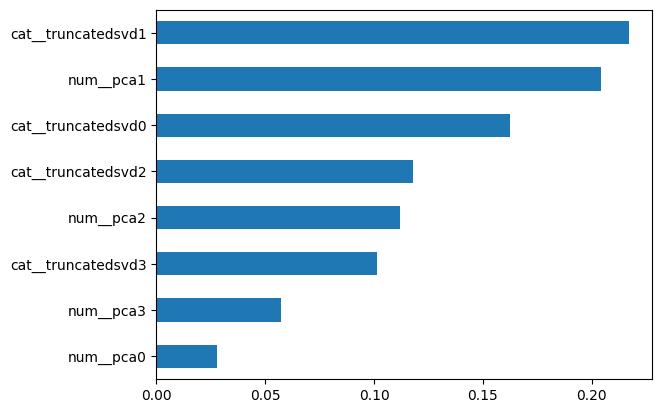

In [80]:
imp.sort_values().plot(kind="barh")

### Out of sample prediction

In [109]:
url2 = "https://raw.githubusercontent.com/utkarshg1/Neural-Net-Datasets/refs/heads/main/test_loan.csv"
xnew = pd.read_csv(url2)
xnew.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
1,58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
2,58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
3,58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
4,58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4


In [110]:
xnew_pre = pre.transform(xnew)
xnew_pre

array([[-0.85399418,  3.94271122,  0.32019881, ..., -0.16806293,
        -0.12600989,  0.05444893],
       [-0.18809036, -0.17993834,  0.86338315, ..., -0.91036174,
        -0.10336819, -0.70672297],
       [-1.13002497, -0.19592683, -1.15322191, ..., -0.57173575,
        -0.22196217, -0.56659564],
       ...,
       [ 5.61746263,  0.73825813, -2.13263021, ...,  0.01621293,
        -0.1539834 , -0.44677389],
       [-1.06311076,  2.84164406, -0.91307382, ..., -0.53435627,
        -0.17433741, -0.61248607],
       [ 1.06270819,  3.21431088, -0.38404652, ...,  0.5646698 ,
        -0.05745417,  0.01426688]])

In [111]:
xnew_pre.shape

(39098, 8)

In [112]:
preds = model.predict(xnew_pre)
preds

array([1, 0, 1, ..., 0, 1, 1])

In [113]:
probs = model.predict_proba(xnew_pre)[:, 1]
probs

array([0.99887973, 0.03987011, 0.78503585, ..., 0.10727286, 0.7835276 ,
       0.9897781 ], dtype=float32)

In [114]:
res = xnew[["id"]]
res.loc[:,"loan_status"] = preds
res.loc[:,"probability"] = probs

In [115]:
res = res.round(4)

In [116]:
res

,id,loan_status,probability
0,58645,1,0.9989
1,58646,0,0.0399
2,58647,1,0.7850
3,58648,0,0.0675
4,58649,0,0.2482
...,...,...,...
39093,97738,0,0.1480
39094,97739,0,0.0083
39095,97740,0,0.1073
39096,97741,1,0.7835


In [117]:
res.to_csv("Results.csv", index=False)

In [118]:
res["loan_status"].value_counts()

,count
loan_status,
0,33670
1,5428


<Axes: xlabel='loan_status'>

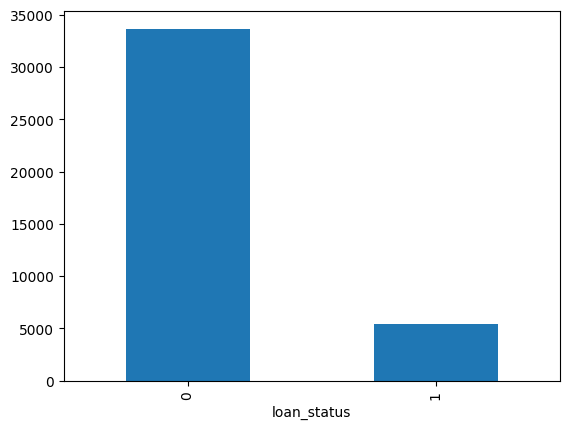

In [119]:
res["loan_status"].value_counts().plot(kind="bar")